In [1]:
import os 
os.chdir('../')
import pandas as pd

In [2]:
dataframe = pd.read_csv('data\cleaned_dataset.csv')

In [3]:
from src.data_handler import DataHandler
data_handler = DataHandler()
smiles_list, features = data_handler.extract_smiles_and_features(dataframe)

In [4]:
features

array([[' Enzyme ', ' Bacteria ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Bacteria ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Bacteria ', ' SINGLE PROTEIN '],
       ...,
       [' Enzyme ', ' Eukaryotes ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Eukaryotes ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Eukaryotes ', ' SINGLE PROTEIN ']], dtype=object)

In [5]:
from src.fingerprint_calculator import FingerprintCalculator
fp_calculator = FingerprintCalculator()

fingerprints = fp_calculator.calculate_fingerprints(smiles_list)

In [15]:
fingerprints.shape

(38370, 512)

In [16]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def estimate_components(data_sample):
    # Assume data_sample is a NumPy array of shape (n_samples, n_features)
    
    # Step 1: Standardize the data
    scaler = StandardScaler()
    data_std = scaler.fit_transform(data_sample)
    
    # Step 2: Fit PCA without reducing dimensions
    pca = PCA(n_components=None)
    pca.fit(data_std)
    
    # Step 3: Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Step 4: Determine the number of components to retain desired variance
    threshold = 0.95  # For 95% variance
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Number of components to retain {threshold*100}% of variance: {n_components}")
    
    # Optional: Plot cumulative explained variance
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of Components')
    plt.grid(True)
    plt.show()
    
    return n_components


Number of components to retain 95.0% of variance: 432


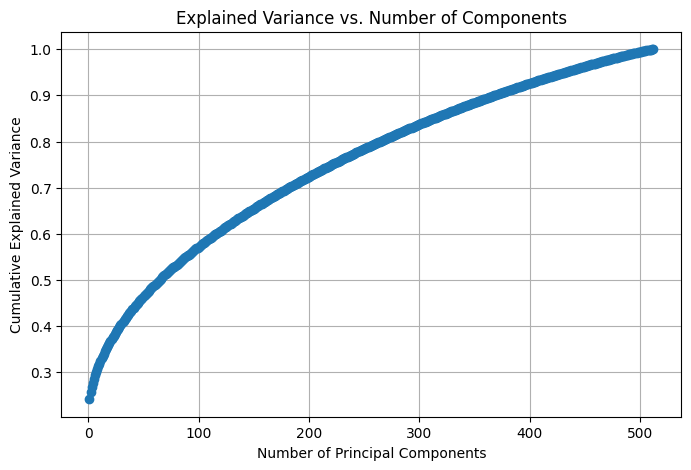

432

In [17]:
estimate_components(fingerprints)

Not good, should look into other FP that can reduce the number of dimensions and still conserve the variance

In [29]:
dataframe = dataframe.drop(columns= ['Target_ID', 'standard_type', 'target_name' 'standard_relation', 'standard_value', 'standard_units', 'Target_organism'])

In [34]:
dataframe.to_csv('data/cleaned_dataset.csv', index = False)

In [ ]:
from config import DATA_FILE_PATH
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder



def one_hot_encode(self, features): 
    one_hot_encoder = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), features)
        ], 
        remainder= 'passthrough' # Keep the rest of columns as is
    )

    oh_features = one_hot_encoder.fit_transform(features)
    return oh_features

def standarize_data(self, data): 
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data)


In [16]:
class DataHandler: 
    def find_input_type(self, file_path=DATA_FILE_PATH):
        self.file_path = file_path
        if file_path.split('.')[-1] == 'csv':
            return True
        elif file_path.split('.')[-1] == 'txt':
            return False 
        else: 
            raise ValueError('Unsupported input file. Only .txt and .csv are supported')

In [ ]:
data_handler = DataHandler()

data_handler.find_input_type(file_path='test.csv')



In [ ]:
from tqdm import tqdm
import pickle


# Load all fingerprints with tqdm progress bar
fingerprints, smiles_list, features = [], [], []
for idx in tqdm(range(75), desc="Loading Fingerprints"):
    with open(f'data/fingerprints_chunk_{idx}.pkl', 'rb') as f:
        fps_chunk, smiles_chunk, features_chunk = pickle.load(f)
        fingerprints.extend(fps_chunk)
        smiles_list.extend(smiles_chunk)
        features.extend(features_chunk)

In [ ]:
from multiprocessing import Pool
from config import N_JOBS
from rdkit import Chem
from mhfp.encoder import MHFPEncoder
smiles = 'CCNC(=O)Nc1cn2c(-c3ncc(C)cn3)cc(-c3cncnc3)cc2n1'

encoder = MHFPEncoder(512)

def calculate_fingerprint(smiles): 
    """Calculate fp for a single SMILES string"""
    fingerprint = encoder.encode(smiles)
    print(fingerprint)
    print(len(fingerprint), type(fingerprint))
    

calculate_fingerprint(smiles)